In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# 1.Load data

In [41]:
deletionlibrary_phenotype = pd.read_excel("../resources/Hayles_2013_OB_merged_categories_sysIDupdated.xlsx")

pre_res = pd.read_csv("../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", sep="\t")
pre_res = pd.merge(pre_res, deletionlibrary_phenotype[["Updated_Systematic_ID", "Consistency at temperatures", "One or multi basic phenotypes", "Category"]], left_on="Systematic ID", right_on="Updated_Systematic_ID", how="left").drop(columns=["Updated_Systematic_ID"])
res = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/constraint3.tsv", sep="\t")
res = pd.merge(res, deletionlibrary_phenotype[["Updated_Systematic_ID", "Consistency at temperatures", "One or multi basic phenotypes", "Category"]], left_on="Systematic ID", right_on="Updated_Systematic_ID", how="left").drop(columns=["Updated_Systematic_ID"])

merged_res = pd.merge(pre_res, res, on=["Systematic ID", "Name", "FYPOviability", "DeletionLibrary_essentiality"], how="inner", suffixes=("_pre", "_post"))

# 2.Plot

In [62]:
pdf = PdfPages("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/curve_fitting_test.pdf")

In [63]:
pre_res[["t1", "t2", "t3", "t4" , "A", "um", "lam"]].hist(bins=40, figsize=(35,5), layout=(1,7))
plt.suptitle("Before modification", fontsize=16)
pdf.savefig(bbox_inches='tight')
plt.close()

In [64]:
res[["t1", "t2", "t3", "t4" , "A", "um", "lam"]].hist(bins=40, figsize=(35,5), layout=(1,7))
plt.suptitle("After modification", fontsize=16)
pdf.savefig(bbox_inches='tight')
plt.close()

In [65]:
fig, ax = plt.subplots(1,6, figsize=(30,5))

for i, col in enumerate(["A", "um", "lam", "R2", "RMSE", "normalized_RMSE"]):
    x = merged_res[col+"_pre"]
    y = merged_res[col+"_post"]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax[i].scatter(x, y, c=z, s=10, cmap='viridis')
    ax[i].set_title(col)
    ax[i].set_xlabel("Before modification")
    ax[i].set_ylabel("After modification")
    ax[i].set_aspect('equal')
    ax[i].grid(True)
    ax[i].set_title(col)

plt.tight_layout()
pdf.savefig(bbox_inches='tight')
plt.close()

In [66]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for idx, df in enumerate([pre_res, res]):
    x = df["um"]
    y = df["lam"]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax[idx].scatter(x, y, c=z, s=10, cmap='viridis')
    ax[idx].set_xlabel("um")
    ax[idx].set_ylabel("lam")
    ax[idx].grid(True)

ax[0].set_title("Before modification")
ax[1].set_title("After modification")

plt.tight_layout()
pdf.savefig(bbox_inches='tight')
plt.close()

In [67]:
pdf.close()

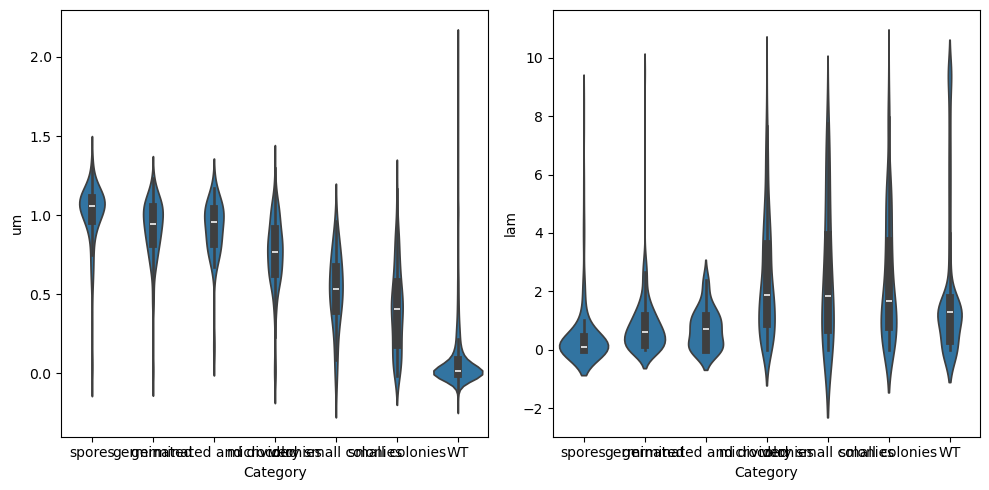

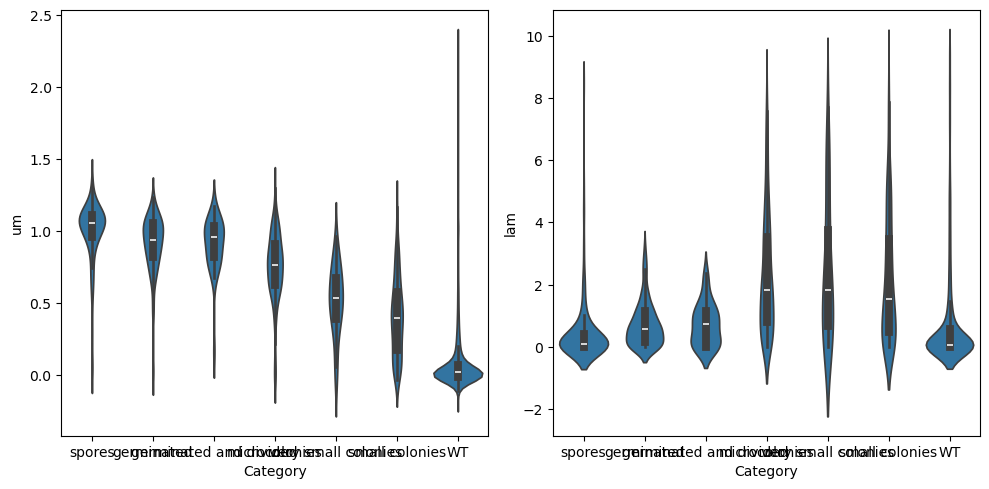

In [47]:
def category_plot(df, selected_categories):

    selected_df = df.query("Category in @selected_categories")

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    sns.violinplot(data=selected_df, x="Category", y="um", ax=ax[0], order=selected_categories)
    sns.violinplot(data=selected_df, x="Category", y="lam", ax=ax[1], order=selected_categories)

    plt.tight_layout()
    plt.show()
    plt.close()

selected_categories = ["spores", "germinated", "germinated and divided", "microcolonies", "very small colonies", "small colonies", "WT"]

category_plot(pre_res, selected_categories)
category_plot(res, selected_categories)

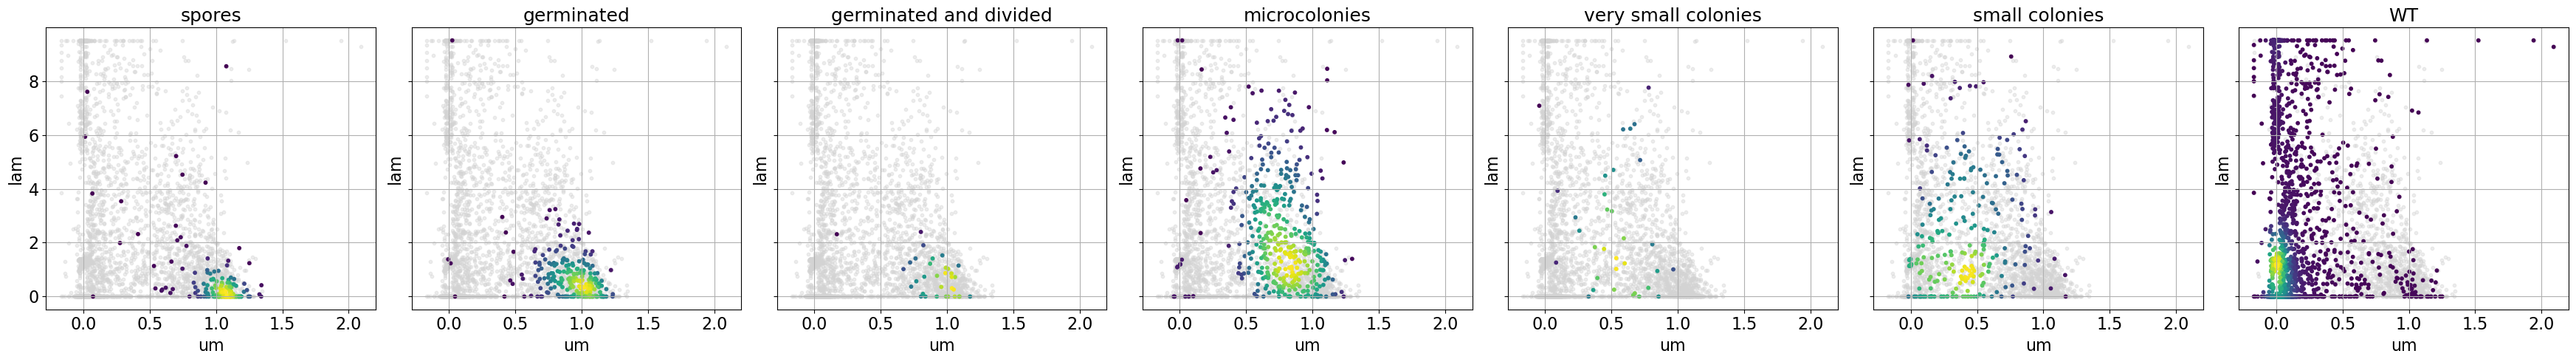

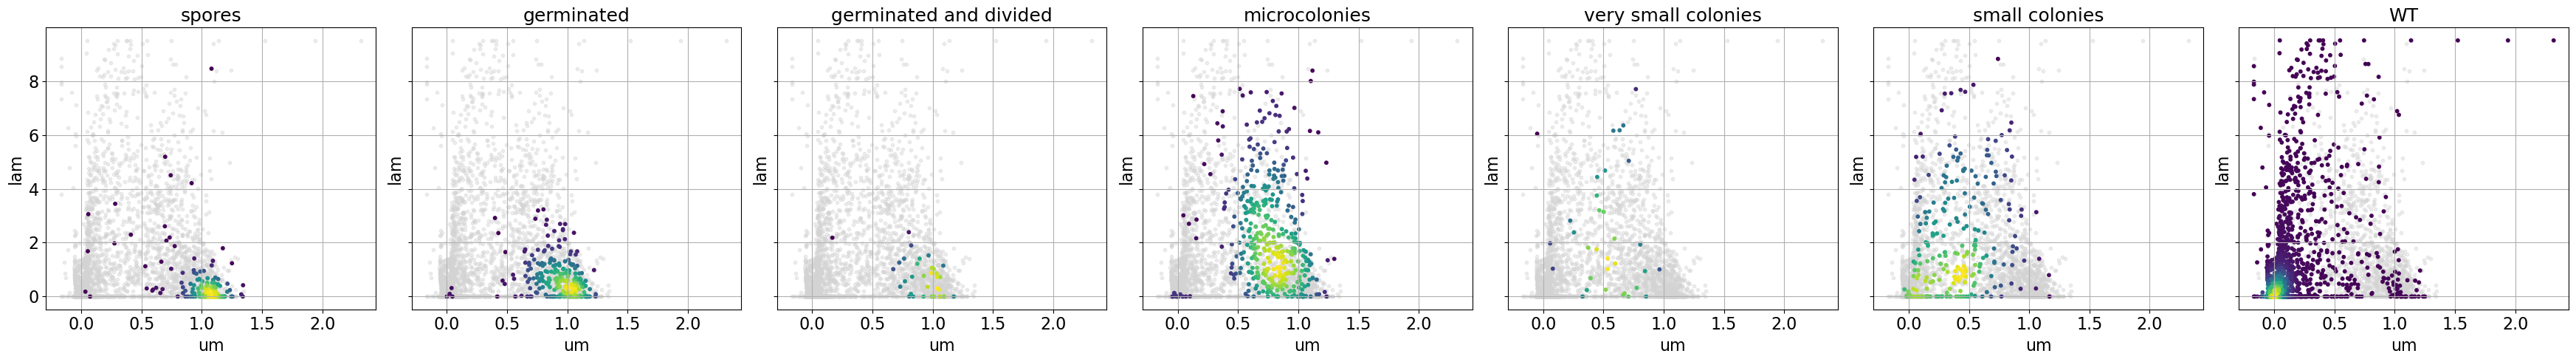

In [53]:
def category_scatter(df, selected_categories):

    selected_df = df.query("Category in @selected_categories")

    fig, ax = plt.subplots(1,len(selected_categories), figsize=(len(selected_categories)*5,5), sharex=True, sharey=True)

    for i, category in enumerate(selected_categories):

        x_all = df["um"]
        y_all = df["lam"]
        ax[i].scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)

        x = selected_df.query("Category == @category")["um"]
        y = selected_df.query("Category == @category")["lam"]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax[i].scatter(x, y, c=z, s=10, cmap='viridis')
        ax[i].set_title(category, fontsize=18)
        ax[i].set_xlabel("um", fontsize=16)
        ax[i].set_ylabel("lam", fontsize=16)
        ax[i].tick_params(axis='both', which='major', labelsize=16)
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

category_scatter(pre_res, selected_categories)
category_scatter(res, selected_categories)

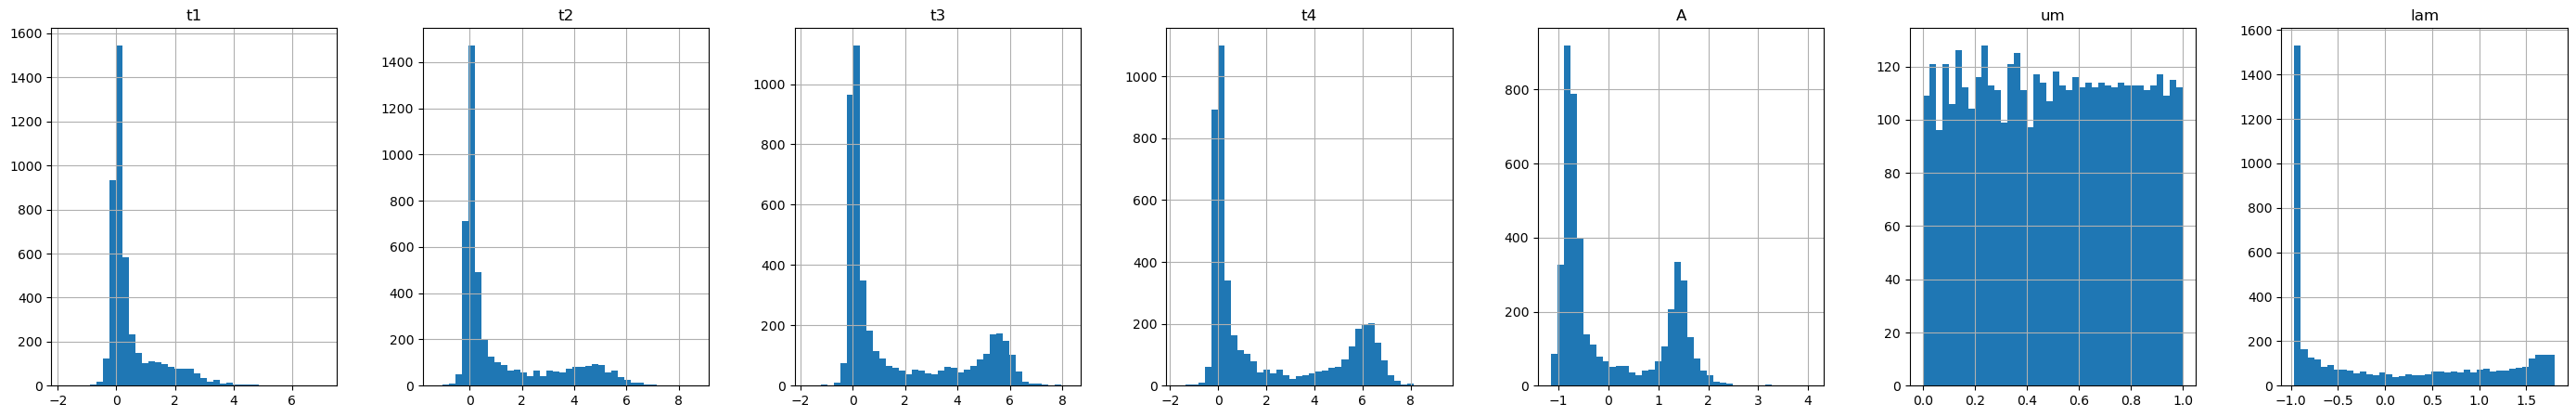

In [26]:
std = StandardScaler()

transformed_data = res.copy()

A = transformed_data["A"].values
A_transformed = std.fit_transform(A.reshape(-1, 1)).flatten()
transformed_data["A"] = A_transformed

um = transformed_data["um"].values
qt = QuantileTransformer(output_distribution='uniform')
um = qt.fit_transform(um.reshape(-1, 1)).flatten()
transformed_data["um"] = um

pt = PowerTransformer(method='yeo-johnson')
lam = transformed_data["lam"].values
lam_transformed = pt.fit_transform(lam.reshape(-1, 1)).flatten()
lam_transformed_std = std.fit_transform(lam_transformed.reshape(-1, 1)).flatten()
transformed_data["lam"] = lam_transformed_std

transformed_data[["t1", "t2", "t3", "t4", "A", "um", "lam"]].hist(bins=40, figsize=(35,5), layout=(1,7))
plt.show()
plt.close()